# Fundus Analysis - Pathological Myopia


In [ ]:
!nvidia-smi

Wed Jan 20 14:13:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**Import Data from Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [4]:
pwd

'/content/gdrive/My Drive/Kaggle'

**Download Data in Colab**

In [ ]:
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k

100% 1.62G/1.62G [00:17<00:00, 52.1MB/s]
100% 1.62G/1.62G [00:17<00:00, 101MB/s] 


In [ ]:
!ls

full_df.csv
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
Kuszma.JPG
ocular-disease-recognition-odir5k.zip
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


**Un-zip the Data**

In [ ]:
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

## Classfication

Import Statements

In [5]:
import numpy as np
import pandas as pd
import cv2
import random
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
import os

In [6]:
df = pd.read_csv("/content/gdrive/My Drive/Kaggle/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [7]:
def has_myopia(text):
    if "pathological myopia" or "myopia" in text:
        return 1
    else:
        return 0

df["left_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
df["right_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_myopia(x))

left_myopia = df.loc[(df.M == 1) & (df.left_myopia == 1)]["Left-Fundus"].values
print(left_myopia[:10])

right_myopia = df.loc[(df.M == 1) & (df.right_myopia == 1)]["Right-Fundus"].values
print(right_myopia[:10])

['13_left.jpg' '16_left.jpg' '18_left.jpg' '35_left.jpg' '46_left.jpg'
 '54_left.jpg' '86_left.jpg' '106_left.jpg' '144_left.jpg' '145_left.jpg']
['13_right.jpg' '16_right.jpg' '18_right.jpg' '35_right.jpg'
 '46_right.jpg' '54_right.jpg' '86_right.jpg' '106_right.jpg'
 '144_right.jpg' '145_right.jpg']


In [8]:
print("Left Eye Images having myopia: {}".format(len(left_myopia)))
print("Right Eye Images having myopia: {}".format(len(right_myopia)))

Left Eye Images having myopia: 306
Right Eye Images having myopia: 306


In [10]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(300,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(300,random_state=42).values

print(left_normal[:10])
print(right_normal[:10])

['3332_left.jpg' '4059_left.jpg' '69_left.jpg' '2415_left.jpg'
 '4176_left.jpg' '2711_left.jpg' '4614_left.jpg' '3174_left.jpg'
 '2862_left.jpg' '2424_left.jpg']
['2964_right.jpg' '680_right.jpg' '500_right.jpg' '2368_right.jpg'
 '2820_right.jpg' '2769_right.jpg' '2696_right.jpg' '2890_right.jpg'
 '940_right.jpg' '2553_right.jpg']


Left and Right Images Together

In [11]:
myopia = np.concatenate((left_myopia,right_myopia),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [13]:
print("myopia: {}".format(len(myopia)))
print("Normal: {}".format(len(normal)))

myopia: 612
Normal: 600


In [14]:
dataset_dir = "/content/gdrive/MyDrive/Kaggle/preprocessed_images/"

image_size = 224

labels = []
dataset = []

def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
        
    random.shuffle(dataset)
    return dataset

In [15]:
dataset = create_dataset(myopia,1)

100%|██████████| 612/612 [01:38<00:00,  6.19it/s]


In [16]:
len(dataset)

576

In [17]:
dataset = create_dataset(normal,0)

100%|██████████| 600/600 [03:02<00:00,  3.28it/s]


In [18]:
len(dataset)

1176

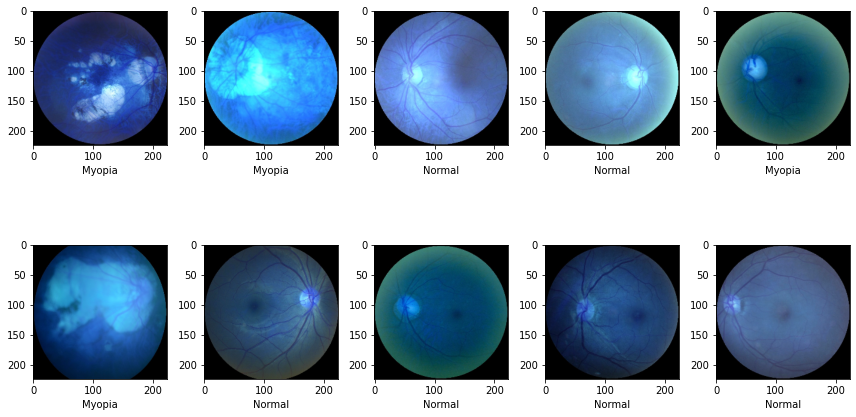

In [19]:
plt.figure(figsize=(12,7))

for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category == 0:
        label = "Normal"
    else:
        label = "Myopia"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()

In [20]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

**Keras Pretrained Models**

In [ ]:
!kaggle datasets download -d gaborfodor/keras-pretrained-models

100% 940M/943M [00:10<00:00, 51.8MB/s]
100% 943M/943M [00:10<00:00, 96.3MB/s]


In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  keras-pretrained-models.zip
replace Kuszma.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Kuszma.JPG              
  inflating: imagenet_class_index.json  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels.h5  
  inflating: xception_weights_tf_dim_ordering_tf_kernels_notop.h5  


In [ ]:
!ls

full_df.csv
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
Kuszma.JPG
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [22]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [23]:
from keras.applications.vgg16 import VGG16, preprocess_input

vgg16_weight_path = '/content/gdrive/MyDrive/Kaggle/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

vgg = VGG16(
    weights = vgg16_weight_path,
    include_top = False, 
    input_shape = (224,224,3)
)

In [24]:
for layer in vgg.layers:
    layer.trainable = False

**Model**

In [25]:
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import Flatten ,Dense

model = Sequential()

model.add(vgg)
model.add(Dense(256, activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(Dense(128, activation='sigmoid'))
model.add(layers.Dropout(rate=0.2))
model.add(Dense(128, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

Model's Summary

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0

In [28]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
history = model.fit(x_train, y_train,
                    batch_size = 32,
                    epochs = 30,
                    validation_data = (x_test, y_test)
                    )

Epoch 1/30
30/30 [==============================] - 14s 166ms/step - loss: 0.7364 - accuracy: 0.5664 - val_loss: 0.3256 - val_accuracy: 0.8814
Epoch 2/30
30/30 [==============================] - 4s 135ms/step - loss: 0.3134 - accuracy: 0.8985 - val_loss: 0.3197 - val_accuracy: 0.8729
Epoch 3/30
30/30 [==============================] - 4s 136ms/step - loss: 0.1924 - accuracy: 0.9313 - val_loss: 0.2582 - val_accuracy: 0.9195
Epoch 4/30
30/30 [==============================] - 4s 137ms/step - loss: 0.1816 - accuracy: 0.9397 - val_loss: 0.2330 - val_accuracy: 0.9322
Epoch 5/30
30/30 [==============================] - 4s 138ms/step - loss: 0.1563 - accuracy: 0.9380 - val_loss: 0.2102 - val_accuracy: 0.9237
Epoch 6/30
30/30 [==============================] - 4s 138ms/step - loss: 0.1177 - accuracy: 0.9535 - val_loss: 0.2422 - val_accuracy: 0.9280
Epoch 7/30
30/30 [==============================] - 4s 139ms/step - loss: 0.1382 - accuracy: 0.9453 - val_loss: 0.1700 - val_accuracy: 0.9492
Epoch

In [35]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [31]:
model.save('fundus_model_MYO.h5')
print('saved')

saved


In [36]:
!ls

full_df.csv
fundus_model_AMD.h5
fundus_model_CAT.h5
fundus_model_MYO.h5
imagenet_class_index.json
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5
inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5
inception_v3_weights_tf_dim_ordering_tf_kernels.h5
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
kaggle.json
ODIR-5K
preprocessed_images
resnet50_weights_tf_dim_ordering_tf_kernels.h5
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
vgg.png
xception_weights_tf_dim_ordering_tf_kernels.h5
xception_weights_tf_dim_ordering_tf_kernels_notop.h5


In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = model.predict_classes(x_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [38]:
accuracy_score(y_test,y_pred)

0.9745762711864406

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       118
           1       0.97      0.97      0.97       118

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236



## Predictions

In [ ]:
# from IPython.display import Image, display

# images = ["/content/gdrive/MyDrive/Kaggle/preprocessed_images/560_right.jpg",
#           "/content/gdrive/MyDrive/Kaggle/preprocessed_images/1550_right.jpg",
#           "/content/gdrive/MyDrive/Kaggle/preprocessed_images/2330_right.jpg",
#           "/content/gdrive/MyDrive/Kaggle/preprocessed_images/0_left.jpg",
#           "/content/gdrive/MyDrive/Kaggle/preprocessed_images/179_right.jpg"]

# for image in images:
#   display(Image(image, width = 120, height = 120))
#   print()

Loaded Model

In [40]:
pwd

'/content/gdrive/My Drive/Kaggle'

In [42]:
from tensorflow import keras

model = keras.models.load_model('/content/gdrive/MyDrive/Kaggle/fundus_model_MYO.h5')
print('loaded')

loaded


In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dense (Dense)                (None, 7, 7, 256)         131328    
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
dense_1 (Dense)              (None, 7, 7, 128)         32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
dense_2 (Dense)              (None, 7, 7, 128)         16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0

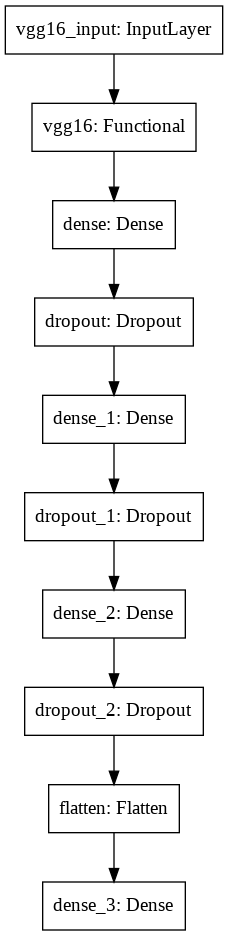

In [44]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='vgg.png')

In [59]:
from keras.preprocessing.image import load_img
 
image = load_img("/content/gdrive/MyDrive/Kaggle/preprocessed_images/179_right.jpg", target_size=(224, 224))

In [60]:
from keras.preprocessing.image import img_to_array
# convert the image pixels to a numpy array
image = img_to_array(image)

In [61]:
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [62]:
from keras.applications.vgg16 import preprocess_input
# prepare the image for the VGG model
image = preprocess_input(image)

Normal Fundus

In [63]:
def disease(predic):
  if predic > 0.75:
    return 'Pathological Myopia'
  return 'Normal'

pred = model.predict(image)
status = disease(pred[0])

print("Situation: {}".format(status))
print("Percentage: {}".format(round(int(pred[0]), 1)))

Situation: Normal
Percentage: 0


Myopic Fundus

In [66]:
def ready_image(img_path):
  image = load_img(img_path, target_size=(224, 224))
  image = img_to_array(image)
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  image = preprocess_input(image)
  return image

image = ready_image("/content/gdrive/MyDrive/Kaggle/preprocessed_images/13_right.jpg")

In [67]:
pred = model.predict(image)
status = disease(pred[0])

print("Situation: {}".format(status))
print("Percentage: {}".format(round(int(pred[0]), 1)))

Situation: Pathological Myopia
Percentage: 0


In [68]:
image = ready_image("/content/gdrive/MyDrive/Kaggle/preprocessed_images/233_right.jpg")

In [69]:
pred = model.predict(image)
status = disease(pred[0])

print("Situation: {}".format(status))
print("Percentage: {}".format(round(int(pred[0]), 1)))

Situation: Pathological Myopia
Percentage: 0
